In [1]:
import tensorflow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import PIL
## checking for xrays and their respective masks
from glob import glob
import re
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU

In [2]:
tensorflow.__version__

'2.17.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_path = '/content/drive/My Drive/Med_Seg/Datasets/Pneum/images/'
# Use defaultdict to store image paths and mask paths
data = defaultdict(list)
image_paths = sorted(glob(root_path + f"*.png"))
mask_paths = []
for path in image_paths:
    mask_path = path.replace('images','masks')
    # mask_path = mask_path.replace('.png','_seg0.png')
    data['image_path'].append(path)
    data['mask_path'].append(mask_path)
print(f"Total Number of Images  : {len(image_paths)}")

Total Number of Images  : 1345


In [5]:
# Create a DataFrame from the defaultdict
df = pd.DataFrame(data)

# Print the total number of images
print(f"Total Number of Images  : {len(image_paths)}")

# Display the DataFrame
print(df)

Total Number of Images  : 1345
                                             image_path  \
0     /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
1     /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
2     /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
3     /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
4     /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
...                                                 ...   
1340  /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
1341  /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
1342  /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
1343  /content/drive/My Drive/Med_Seg/Datasets/Pneum...   
1344  /content/drive/My Drive/Med_Seg/Datasets/Pneum...   

                                              mask_path  
0     /content/drive/My Drive/Med_Seg/Datasets/Pneum...  
1     /content/drive/My Drive/Med_Seg/Datasets/Pneum...  
2     /content/drive/My Drive/Med_Seg/Datasets/Pneum...  
3     /content/drive/My Driv

In [6]:
df = df.iloc[0:800]

In [7]:
# DIR = "/content/drive/My Drive/Med_Seg/Datasets/"

# lung_image_paths = glob(os.path.join(DIR,"Pneum/images/*.png"))
# mask_image_paths = glob(os.path.join(DIR,"Pneum/masks/*.png"))

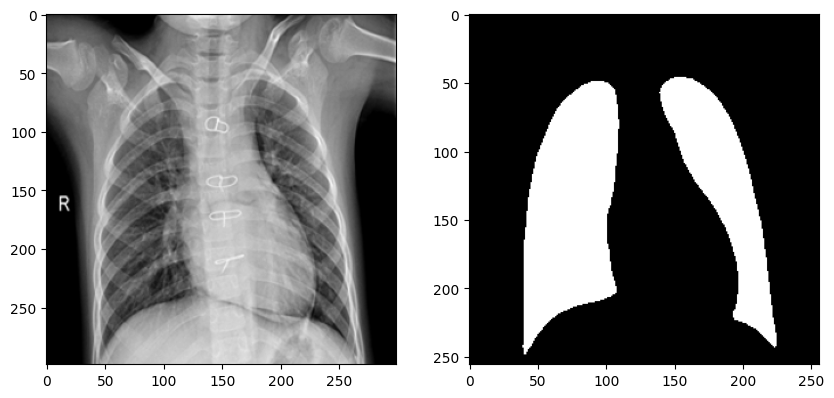

In [8]:
xray_num = 5
img_path = df["image_path"][xray_num]
mask_path = df["mask_path"][xray_num]

img = PIL.Image.open(img_path)
mask = PIL.Image.open(mask_path)

fig = plt.figure(figsize = (10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img, cmap = "gray")
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(mask, cmap = "gray")

In [9]:

from tqdm import tqdm
import cv2
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)

    for mask_path in tqdm(df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = df, resize_shape = (256,256), color_mode = "gray")

100%|██████████| 800/800 [08:41<00:00,  1.53it/s]


In [10]:
from sklearn.model_selection import train_test_split
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

img_side_size = 256
img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

In [11]:
### U-net

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.metrics import F1Score, Precision, Recall
# from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.activations import *
from tensorflow.keras import backend as K


def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [12]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy", \
                  metrics=[dice_coef,Precision(),Recall(), 'binary_accuracy', MeanIoU(num_classes=2, name="IoU")])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 256)    │        524,544 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(x = img_train,
                    y = mask_train,
                    validation_data = (img_test, mask_test),
                    epochs = 10,
                    batch_size = 16,
                   callbacks = [earlystopping])

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 591ms/step - IoU: 0.3643 - binary_accuracy: 0.7666 - dice_coef: 0.2742 - loss: 0.5896 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_IoU: 0.3839 - val_binary_accuracy: 0.7678 - val_dice_coef: 0.3175 - val_loss: 0.4565 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 288ms/step - IoU: 0.3641 - binary_accuracy: 0.7766 - dice_coef: 0.3530 - loss: 0.4361 - precision: 0.4495 - recall: 0.0908 - val_IoU: 0.3839 - val_binary_accuracy: 0.8616 - val_dice_coef: 0.5764 - val_loss: 0.3066 - val_precision: 0.7140 - val_recall: 0.6741
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - IoU: 0.3640 - binary_accuracy: 0.8719 - dice_coef: 0.6029 - loss: 0.2866 - precision: 0.7632 - recall: 0.6551 - val_IoU: 0.3839 - val_binary_accuracy: 0.9306 - val_dice_coef: 0.7836 - val_loss: 0.1733 - val_precision: 0.8540 - val_recall: 0.8455
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - IoU: 0.3644 - binary_accur

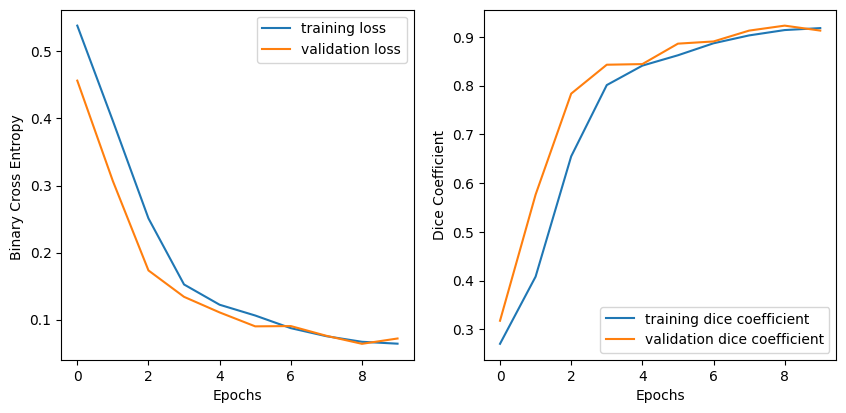

In [14]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Binary Cross Entropy ")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Dice Coefficient")

get_metrics(history = history)

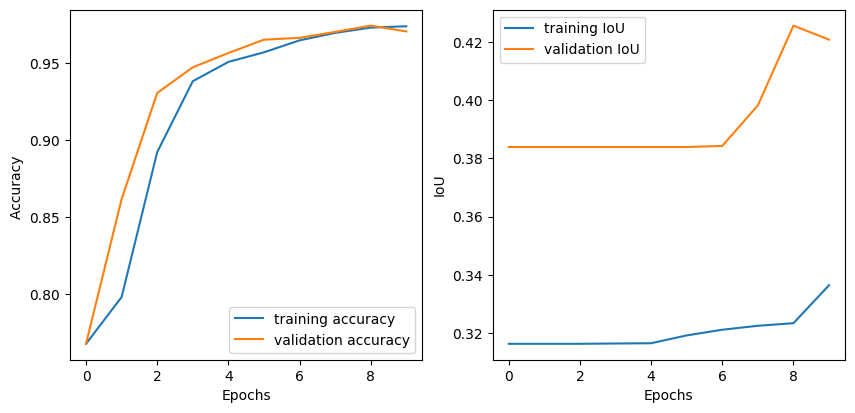

In [15]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["binary_accuracy"], label = "training accuracy")
    plt.plot(history.history["val_binary_accuracy"], label = "validation accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy ")

    plt.subplot(2,2,2)
    plt.plot(history.history["IoU"], label = "training IoU")
    plt.plot(history.history["val_IoU"], label = "validation IoU")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
get_metrics(history = history)

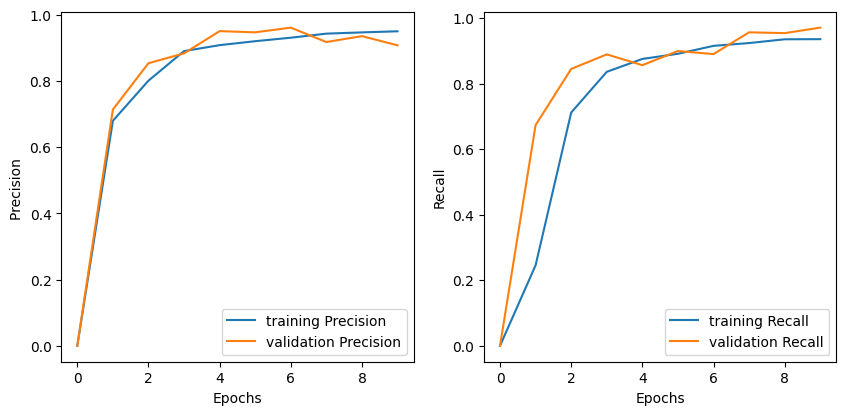

In [16]:
def get_metrics(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["precision"], label = "training Precision")
    plt.plot(history.history["val_precision"], label = "validation Precision")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Precision ")

    plt.subplot(2,2,2)
    plt.plot(history.history["recall"], label = "training Recall")
    plt.plot(history.history["val_recall"], label = "validation Recall")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
get_metrics(history = history)

In [18]:
accuracy = history.history["val_binary_accuracy"]
precision = history.history["val_precision"]
recall = history.history["val_recall"]
iou = history.history["val_IoU"]
dice_coef = history.history["val_dice_coef"]
print("The Accuracy of the UNET model:",round(accuracy[-1],2))
print("The Precision of the UNET model:",round(precision[-1],2))
print("The Recall of the UNET model:",round(recall[-1],2))
print("The IOU Score of the UNET model:",round(iou[-1],2))
print("The Dice Score of the UNET model:",round(dice_coef[-1],2))



The Accuracy of the UNET model: 0.97
The Precision of the UNET model: 0.91
The Recall of the UNET model: 0.97
The IOU Score of the UNET model: 0.42
The Dice Score of the UNET model: 0.91


In [19]:
def test_on_images(model, img_array, mask_array, img_side_size=128):
    num_images = img_array.shape[0]
    predictions = []
    dice_scores = []

    for img_num in range(num_images):
        pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
        pred[pred > 0.5] = 1.0
        pred[pred < 0.5] = 0.0
        predictions.append(pred)

        fig = plt.figure(figsize=(15, 10))
        plt.subplot(1, 4, 1)
        plt.imshow(pred.reshape(img_side_size, img_side_size), cmap="Blues")
        plt.title("Prediction")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(mask_array[img_num].reshape(img_side_size, img_side_size), cmap="Blues")
        plt.title("Original Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.show()

    return predictions

# Assuming img_test and mask_test are the image and mask arrays
predictions = test_on_images(model, img_array=img_test, mask_array=mask_test, img_side_size=256)



Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

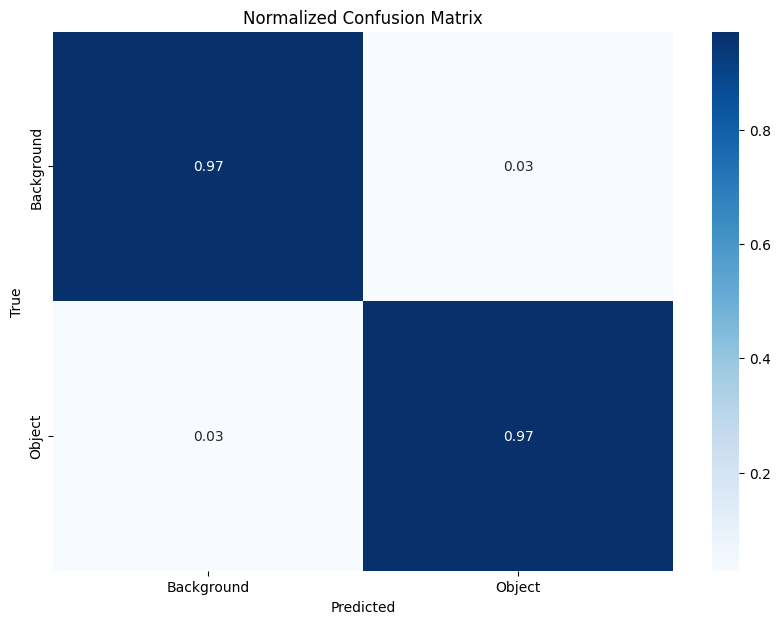

Confusion Matrix (Raw):
 [[7811268  239734]
 [  69055 2365703]]


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_on_image(model, img_array, img_num, img_side_size=256):
    pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
    pred[pred > 0.5] = 1.0
    pred[pred <= 0.5] = 0.0
    return pred

def get_predictions_and_true_masks(model, img_test, mask_test, img_side_size=256):
    y_true = []
    y_pred = []
    for i in range(len(img_test)):
        prediction = test_on_image(model, img_array=img_test, img_num=i, img_side_size=img_side_size)
        y_true.append(mask_test[i].flatten())
        y_pred.append(prediction.flatten())
    return np.concatenate(y_true), np.concatenate(y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, normalize=False):
    plt.figure(figsize=(10, 7))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Get the true and predicted values
y_true, y_pred = get_predictions_and_true_masks(model, img_test, mask_test)

# Ensure the predictions are binary
y_pred = np.round(y_pred).astype(int)
y_true = np.round(y_true).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names=["Background", "Object"], normalize=True)
# plot_confusion_matrix(cm, class_names=["Background", "Object"], normalize=False)

print("Confusion Matrix (Raw):\n", cm)
# print("Confusion Matrix (Normalized):\n", cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

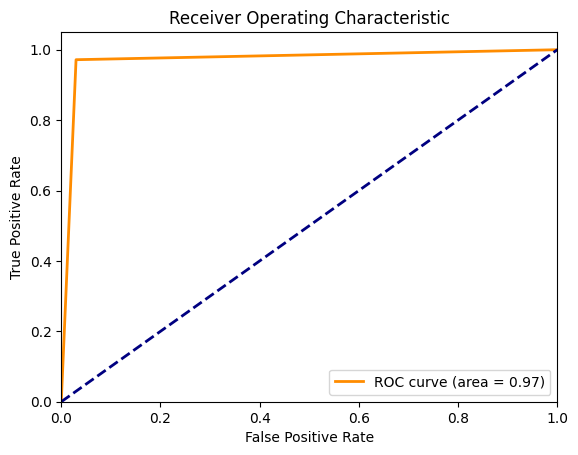

ROC AUC: 0.9709304618075886


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming the function to get true and predicted masks is defined as:
def get_predictions_and_true_masks(model, img_test, mask_test, img_side_size=256):
    y_true = []
    y_pred = []
    for i in range(len(img_test)):
        prediction = test_on_image(model, img_array=img_test, img_num=i, img_side_size=img_side_size)
        y_true.append(mask_test[i].flatten())
        y_pred.append(prediction.flatten())
    return np.concatenate(y_true), np.concatenate(y_pred)

# Get the true and predicted values
y_true, y_pred = get_predictions_and_true_masks(model, img_test, mask_test)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc}")